# Исправление временного сдвига для событий 2013г 

In [1]:
!date
!pwd
!ls ./data

Ср май 30 11:28:37 MSK 2018
/home/sphere/github/Sphere/Data2013
10675.txt	11358.txt	11588.txt	flight1.dbg.2013.dat
10675.txt.old	11362.txt	11588.work.csv	flight1.dbg.dat
10675.work.csv	11368.txt	11588.work.txt	flight2.dbg.2013.dat
10675.work.txt	11418.txt	11589.frame	flight2.dbg.dat
11284.txt	11452.frame	11589.work.csv	flight3.dbg.2013.dat
11286.txt	11452.toff	11589.work.txt	flight3.dbg.dat
11286.work.csv	11452.txt	12114.frame	flight4.dbg.2013.dat
11302.txt	11452.work.csv	12114.toff	flight4.dbg.dat
11302.work.csv	11468.txt	12114.txt	flight5.dbg.2013.dat
11308.frame	11468.work.csv	12114.work.csv	flight5.dbg.dat
11308.toff	11588.dat	cal		height_2013.csv
11308.txt	11588.frame	datum_2013.csv	minus_pied_csv
11308.work.csv	11588.toff	exotic


In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns

In [3]:
plt.rcParams['figure.figsize'] =(12,6)
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 12

In [22]:
def read_file(filename):
    # считать данные, заменив 0 на NaN
    na_values = ['NO CLUE', 'N/A', '0']
    datum = pd.read_csv(filename, na_values=na_values, header = None, index_col=False, sep=',')

    # убрать последние три канала
    param = [i for i in range(109)]
    datum = datum[param]

    # отрицательные значения заменить на маленькое положительное 0.001
    # маленькие значения (< minshow) заменить на маленькое положительное minpos = 0.0001
    minshow = 0.01
    minpos = 0.0001
    for i in range(datum.shape[1]):
        zero_cell = datum[i] <= minshow
        datum.loc[zero_cell, i] = minpos
    datum.fillna(0.001, inplace = True)
    datum.shape   
    return datum

In [23]:
def draw_one_frame(datum, ax, i, title):
    colorscale = "gist_yarg"
    cbar = True
    xt, yt = 0, 1
    xb, yb = 108.1, 969
    sns.heatmap(np.log(datum), ax=ax, cmap = colorscale,
                cbar=i == 0,
                vmin=0, 
                xticklabels=20, yticklabels=200,
                #cbar_ax  = None if i else cbar_ax,
                #cbar_kws = None if i else cbar_kws
               )
    ax.plot(( xt, xt),( yt, yb),'k')
    ax.plot(( xt, xb),( yb, yb),'k')
    ax.plot(( xb, xb),( yb, yt),'k')
    ax.plot(( xt, xb),( yt, yt),'k')
    #ax.axhline(y=427,linewidth=1, color='r') 
    ax.set_title(title)
    ax.set_xlabel('N, PMT number')
    if i == 0:
        ax.set_ylabel('T, Time bin number')
    
def draw_five_frames(frame):
    colorscale = "gist_yarg"
    fig, axn = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(12,6))
    cbar_ax  = fig.add_axes([.91, .12, .02, .78])
    cbar_kws = {"label":'log10 (A)'}
    cbar = False
    xt, yt = 0, 1
    xb, yb = 108.1, 969

    for (i, ax), datum in zip(enumerate(axn.flat), frame):
        sns.heatmap(np.log(datum), ax=ax, cmap = colorscale,
                    cbar=i == 0,
                    vmin=0, 
                    xticklabels=20, yticklabels=200,
                    cbar_ax  = None if i else cbar_ax,
                    cbar_kws = None if i else cbar_kws
                   )
        ax.plot(( xt, xt),( yt, yb),'k')
        ax.plot(( xt, xb),( yb, yb),'k')
        ax.plot(( xb, xb),( yb, yt),'k')
        ax.plot(( xt, xb),( yt, yt),'k')
        #ax.axhline(y=427,linewidth=1, color='r') 
        ax.set_title(title[i])
        ax.set_xlabel('N, PMT number')
        if i == 0:
            ax.set_ylabel('T, Time bin number')


## Read data

In [24]:
# read five frames
frame = []
title = []
for i in range(5):
    name = 'data/minus_pied_csv/' + str(10675+i) + '.csv'
    data = read_file(name)
    frame.append(data)
    title.append(str(10675+i))
print('Read %d files' % len(frame) )

Read 5 files


### Frames before calibration and time drift corrections

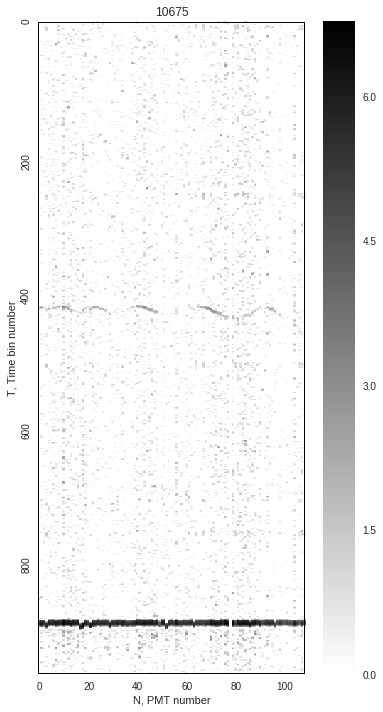

In [25]:
fig, axn = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,12))
draw_one_frame(frame[0],axn,0,title[0])

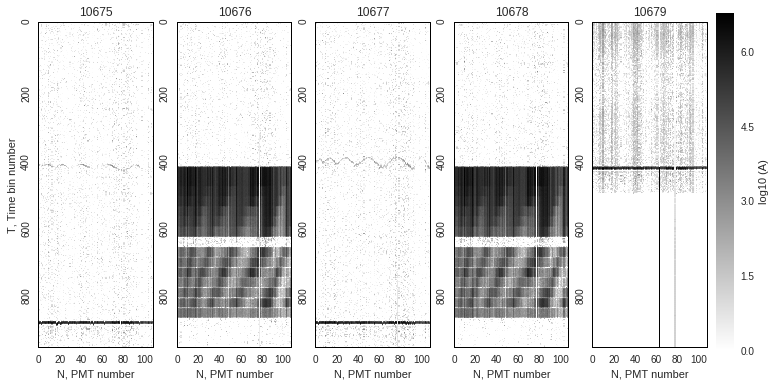

In [26]:
draw_five_frames(frame)

### Time Drift correction

In [27]:
### caclulate the drift
def shift_calc(frame):
    tmin, tmax = 850, 930 
    #if fr == 1:
        #tmin, tmax = 400,487
    cumsum1 = frame[tmin:tmax].cumsum()
    half = cumsum1[:][len(cumsum1)-1:len(cumsum1)]/2
    idx = []
    for i in range(109):
        idx.append(cumsum1[i][cumsum1[i] > float(half[i])].index.min())
    idx = pd.DataFrame(idx)
    shi = idx - int(idx.mean())
    return list(shi[0])

In [28]:
import copy
### apply drift to data
def shift_make(frame, shift):
    dim = frame.shape[0]
    minpos = 0.00001
    oldframe = copy.deepcopy(frame)
    newframe = copy.deepcopy(frame)
    for chan in range(109):
        drift = shift[chan]
        if drift > 0:
            for i in range(dim - drift):
                #if fr == 1 and chan == 78 : print('chan=',chan, drift, i, i + drift)
                newframe.loc[i, chan] = oldframe[chan][i + drift]
            for i in range(dim - drift, dim):
                newframe.loc[i, chan] = minpos
        if drift < 0:
            drift *= -1
            for i in range(dim-1, drift-1, -1):
                newframe.loc[i, chan] = oldframe[chan][i - drift]
            for i in range(0,drift):
                newframe.loc[i, chan] = minpos
    return newframe

In [29]:
### считаем сдвиг в каналах ###
shift = []
for fr in range(len(frame)):
    shift.append(shift_calc(frame[fr]))
print(shift[0])

[1, 1, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 4, 0, 1, 4, 1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 5, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, -3, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


In [30]:
### производим сдвиг в каналах ###
nframe = []

for fr in range(len(frame)):
    print('fr=',fr)
    newframe = shift_make(frame[fr],shift[fr])
    nframe.append(newframe)

fr= 0
fr= 1
fr= 2
fr= 3
fr= 4


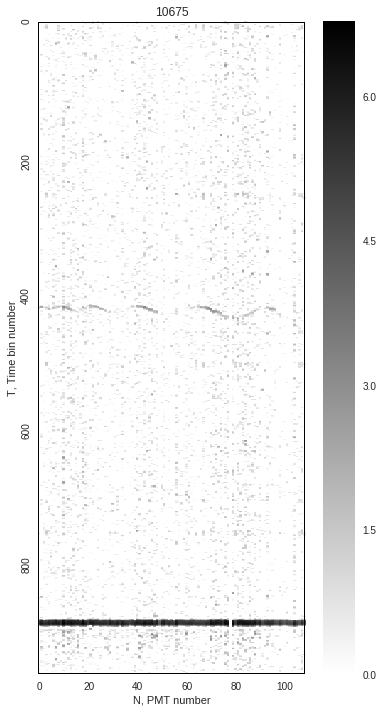

In [31]:
fig, axn = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,12))
draw_one_frame(nframe[0],axn,0,title[0])

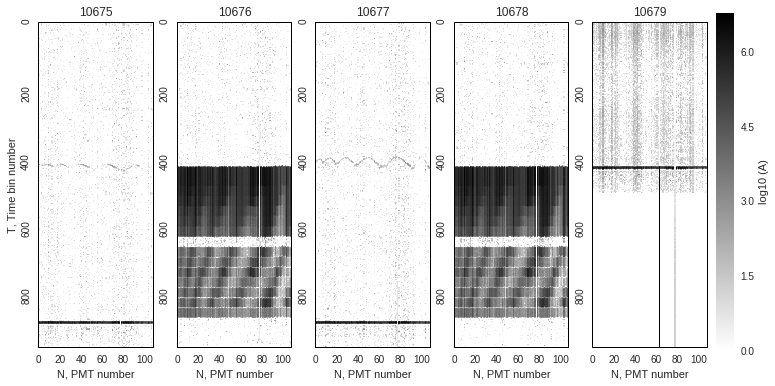

In [19]:
# control of time drift correction
draw_five_frames(nframe)

In [20]:
# save shifted frame data to file
nameout = 'data/shifted_csv/shifted' + str(10675+i) + '.csv'
nframe[0].to_csv(nameout)